In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
import torch
import json
import pandas as pd
import gc as gc
import numpy as np
from datasets import Dataset
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import statistics

/home/niccolo/Torino/LLM-SamEval-T5/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [ ]:
TRAIN_JSON_FILE = "../data/train.json"
DEV_JSON_FILE = "../data/dev.json"
OUTPUT_DIR = "../smollm-finetune-360M"

In [5]:
def load_data(file_path):
    """
    Loads the json containing the dataset and return a pandas dataframe.
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    # Transpose because the json is {id: {features...}, ...}
    df = pd.DataFrame(data).T
    # Ensure 'average' is float
    df['average'] = df['average'].astype(float)
    # Ensure 'choices' is list (for scoring later)
    return df

df_train = load_data(TRAIN_JSON_FILE)
df_dev = load_data(DEV_JSON_FILE)

# Convert to HF Dataset
# We keep the index as 'id' column
df_train['id'] = df_train.index
df_dev['id'] = df_dev.index

full_train_dataset = Dataset.from_pandas(df_train)
dev_dataset = Dataset.from_pandas(df_dev)

# Split train_dataset into train and validation (e.g., 10% for validation)
# This ensures the model doesn't see the dev set during training
train_val_split = full_train_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = train_val_split['train']
eval_dataset = train_val_split['test']

print(f"Train size: {len(train_dataset)}")
print(f"Eval (from Train) size: {len(eval_dataset)}")
print(f"Dev (Holdout) size: {len(dev_dataset)}")

Train size: 2052
Eval (from Train) size: 228
Dev (Holdout) size: 588


In [6]:
df_train.head()

,homonym,judged_meaning,precontext,sentence,ending,choices,average,stdev,nonsensical,sample_id,example_sentence,id
0,potential,the difference in electrical charge between tw...,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,She collected a battery reader and looked on e...,"[4, 5, 2, 3, 1]",3.0,1.581139,"[False, False, False, False, False]",1843,The circuit has a high potential difference.,0
1,potential,the inherent capacity for coming into being,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,She collected a battery reader and looked on e...,"[5, 3, 4, 4, 3]",3.8,0.83666,"[False, False, False, False, False]",1844,The project has great potential for success.,1
2,potential,the difference in electrical charge between tw...,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,The machine could make such wonderful clothing...,"[2, 1, 4, 3, 1]",2.2,1.30384,"[False, False, False, False, False]",1845,The circuit has a high potential difference.,2
3,potential,the inherent capacity for coming into being,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,The machine could make such wonderful clothing...,"[4, 5, 5, 3, 5]",4.4,0.894427,"[False, False, False, False, False]",1846,The project has great potential for success.,3
4,potential,the difference in electrical charge between tw...,The old machine hummed in the corner of the wo...,The potential couldn't be measured.,,"[1, 1, 4, 4, 3]",2.6,1.516575,"[False, False, False, False, False]",1847,The circuit has a high potential difference.,4


In [ ]:
model_name = "HuggingFaceTB/SmolLM-360M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [8]:
def preprocess_function(data):
    """
    Construct tokenized Premise and Hypothesis for the NLI model.
    Premise: {precontext} {sentence} {ending}
    Hypothesis: The definition of "{homonym}" is: "{judged_meaning}" as in the following sentence: "{example_sentence}"
    """

    premises = [
        f"{p} {s} {e}" for p, s, e in zip(data['precontext'], data['sentence'], data['ending'])
    ]
    hypotheses = [
        f'The definition of "{h}" is: "{j}" as in the following sentence: "{ex}"' 
        for h, j, ex in zip(data['homonym'], data['judged_meaning'], data['example_sentence'])
    ]
    
    # Tokenize
    # REMOVED padding="max_length" to save memory and allow dynamic padding
    model_inputs = tokenizer(premises, hypotheses, max_length=100, truncation=True)
    
    # Labels: 'average' column
    # Scale to 0-1 based on range 0.5 - 5.5
    model_inputs["labels"] = [(x - 0.5) / 5.0 for x in data["average"]]
    
    return model_inputs

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_eval = eval_dataset.map(preprocess_function, batched=True)
tokenized_dev = dev_dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 588/588 [00:00<00:00, 12418.18 examples/s]


In [9]:
# Check token lengths
# Here max_length is set to 128. But if you don't set it in the cell above you'll get the real results.
lengths = [len(x) for x in tokenized_train['input_ids']]
print(f"Max length: {max(lengths)}")
print(f"Average length: {sum(lengths)/len(lengths)}")
import pandas as pd
print(pd.Series(lengths).describe(percentiles=[0.9, 0.95, 0.99]))

Max length: 100
Average length: 91.6842105263158
count    2052.000000
mean       91.684211
std         8.970110
min        61.000000
50%        95.000000
90%       100.000000
95%       100.000000
99%       100.000000
max       100.000000
dtype: float64


In [10]:
# Load model for regression (num_labels=1)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=1, 
    problem_type="regression",
)
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 101.54it/s]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at HuggingFaceTB/SmolLM-1.7B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 101.54it/s]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at HuggingFaceTB/SmolLM-1.7B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 2048)
    (layers): ModuleList(
      (0-23): 24 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps

In [ ]:
# Clear cache to free up fragmented memory
torch.cuda.empty_cache()

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.squeeze()
    
    # Rescale predictions to 0.5 - 5.5
    predictions = predictions * 5.0 + 0.5
    
    # Check if we are evaluating on the validation set
    if len(predictions) == len(eval_dataset):
        gold_choices = eval_dataset['choices']
        gold_averages = eval_dataset['average']
    else:
        # Fallback for other datasets
        gold_choices = None
        gold_averages = labels * 5.0 + 0.5
    
    # Spearman
    spearman_corr, _ = spearmanr(predictions, gold_averages)
    
    metrics = {"spearman": spearman_corr}

    # Accuracy (only if we have choices)
    if gold_choices is not None:
        accuracies = []
        for pred, choices in zip(predictions, gold_choices):
            avg = sum(choices)/len(choices)
            stdev = statistics.stdev(choices)
            if (avg - stdev) < pred < (avg + stdev):
                accuracies.append(1)
            elif abs(avg - pred) < 1:
                accuracies.append(1)
            else:
                accuracies.append(0)
        accuracy = sum(accuracies) / len(accuracies)
        metrics["accuracy"] = accuracy
        metrics["combined_score"] = (spearman_corr + accuracy) / 2
    else:
        metrics["combined_score"] = spearman_corr

    return metrics

training_args = TrainingArguments(
    output_dir=f"{OUTPUT_DIR}/model/",
    num_train_epochs=6,
    per_device_train_batch_size=8, # Reduced to 2 for 1.7B model
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=1,
    logging_dir=f"{OUTPUT_DIR}/logs/",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="combined_score",
    learning_rate=2e-5,
    save_total_limit=2,
    remove_unused_columns=True,
    warmup_ratio=0.06,
    weight_decay=0.01,
    fp16=True,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    optim="adafactor"
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [12]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 7.62 GiB of which 19.25 MiB is free. Including non-PyTorch memory, this process has 7.59 GiB memory in use. Of the allocated memory 7.46 GiB is allocated by PyTorch, and 16.07 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

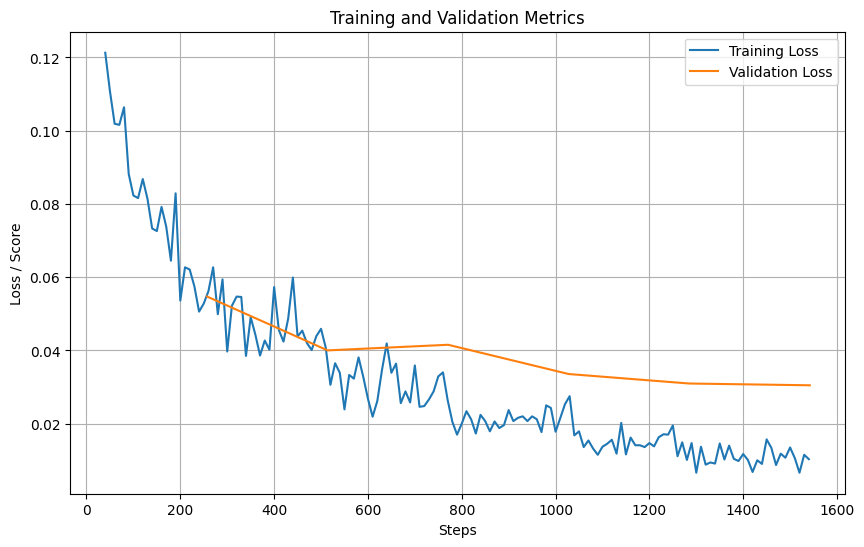

In [ ]:
# Extract loss history
history = trainer.state.log_history
train_loss = []
eval_loss = []
train_steps = []
eval_steps = []
spearman = []
accuracy = []
combined_score = []
spearman_steps = []

for entry in history:
    if 'loss' in entry:
        train_loss.append(entry['loss'])
        train_steps.append(entry['step'])
    if 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        eval_steps.append(entry['step'])
    if 'eval_spearman' in entry:
        spearman.append(entry['eval_spearman'])
        accuracy.append(entry['eval_accuracy'])
        combined_score.append(entry['eval_combined_score'])
        spearman_steps.append(entry['step'])

        

#remove first two point (usually very high due to initialization)
if len(train_loss) > 3:
    train_loss = train_loss[3:]
    train_steps = train_steps[3:]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label='Training Loss')
plt.plot(eval_steps, eval_loss, label='Validation Loss')
# plt.plot(spearman_steps, spearman, label='Spearman score')
# plt.plot(spearman_steps, accuracy, label='Accuracy')
# plt.plot(spearman_steps, combined_score, label='Combined Score')
plt.xlabel('Steps')
plt.ylabel('Loss / Score')
plt.title('Training and Validation Metrics')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Generate predictions on dev set
predictions = trainer.predict(tokenized_dev)
preds = predictions.predictions.squeeze()

# Prepare for scoring.py
output_data = []
for idx, pred in zip(df_dev['id'], preds):
    # Rescale
    rescaled_pred = float(pred) * 5.0 + 0.5
    # Clamp prediction between 0.5 and 5.5
    final_pred = max(0.5, min(5.5, rescaled_pred))
    output_data.append({"id": str(idx), "prediction": final_pred})

output_file = f"{OUTPUT_DIR}/predictions.jsonl"
with open(output_file, "w") as f:
    for item in output_data:
        f.write(json.dumps(item) + "\n")

print(f"Predictions saved to {output_file}")

# Create dev_gold.jsonl for scoring
gold_data = []
for idx, row in df_dev.iterrows():
    gold_data.append({"id": str(idx), "label": row["choices"]})

gold_file = f"{OUTPUT_DIR}/ref.jsonl"
with open(gold_file, "w") as f:
    for item in gold_data:
        f.write(json.dumps(item) + "\n")

print(f"Gold data saved to {gold_file}")

# Run scoring script
import os
os.system(f"python ../score/scoring.py {OUTPUT_DIR}/ref.jsonl {OUTPUT_DIR}/predictions.jsonl {OUTPUT_DIR}/score.json")

Predictions saved to ../smollm-finetune-360M/predictions.jsonl
Gold data saved to ../smollm-finetune-360M/ref.jsonl
Importing...
Starting Scoring script...
['{"id": "37", "prediction": 0.511444091796875}\n', '{"id": "39", "prediction": 0.5}\n', '{"id": "41", "prediction": 0.567291259765625}\n', '{"id": "205", "prediction": 0.5}\n', '{"id": "207", "prediction": 0.88787841796875}\n']
Everything looks OK. Evaluating file ../smollm-finetune-360M/predictions.jsonl on ../smollm-finetune-360M/ref.jsonl
----------
Spearman Correlation: 0.43227680554285947
Spearman p-Value: 3.604301091932674e-28
----------
Accuracy: 0.7023809523809523 (413/588)
Results dumped into scores.json successfully.
Starting Scoring script...
['{"id": "37", "prediction": 0.511444091796875}\n', '{"id": "39", "prediction": 0.5}\n', '{"id": "41", "prediction": 0.567291259765625}\n', '{"id": "205", "prediction": 0.5}\n', '{"id": "207", "prediction": 0.88787841796875}\n']
Everything looks OK. Evaluating file ../smollm-finetun

0